# 树回归
主要内容：
> 1. CART算法
> 2. 回归与模型树
> 3. 树剪枝算法
> 4. Python GUI

## 1. 复杂数据的局部性建模
树回归算法：
> 优点：可以对复杂和非线性的数据建模<br>
> 缺点：结果不易理解<br>
> 适用数据类型：数值型和标称型数据

树回归的一般方法：
> 1. 收集数据：采用任意方法收集数据。
> 2. 准备数据：需要数值型的数据，标称型数据应该映射成二值型数据。
> 3. 分析数据：绘出数据的二维可视化显示结果，以字典方式生成树。
> 4. 训练算法：大部分时间都花费在叶节点树模型的构建上。
> 5. 测试算法：使用测试数据上的R2值来分析模型的效果。
> 6. 使用算法：使用训练出的树做预测，预测结果还可以用来做很多事情

In [45]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        # python3不适用：fltLine = map(float,curLine) 修改为： 
        fltLine = [float(x) for x in curLine]
        dataMat.append(fltLine)
    return dataMat

def binSplitDataSet(dataSet, feature, value):
    """
    将数据集按照feature列和value进行二元切分
    Description : 在给定特征和特征值的情况下，该函数通过数组过滤的方式将dataSet切分为两个子集并返回
    """
    # nonzero返回数组中不为0元素的下标
    # 这里先将dataSet中第feature列大于value的置为1，小于value的置为0，然后取所有为1的样本
    # 原书代码报错：'index out of bound'
    # mat0 = dataSet[np.nonzero(dataSet[:, feature] > value)[0], :][0]
    # mat1 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0], :][0]
    mat0 = dataSet[np.nonzero(dataSet[:, feature] > value)[0], :]
    mat1 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0], :]
    return mat0, mat1

第3章时使用信息熵来计算数据的混乱程度，在连续型数据值上，我们可以通过计算每个数据到均值的距离，使用所有数据的总方差来代表数据的混乱度。<br>
下面的chooseBestSplit函数主要完成：用最佳的方式切分数据集和生成相应的叶节点。

In [37]:
def regLeaf(dataSet):
    """负责生成叶节点，用聚类中心代表这团数据"""
    return np.mean(dataSet[:, -1])

def regErr(dataSet):
    """计算总方差"""
    return np.var(dataSet[:, -1]) * dataSet.shape[0]

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    """用最佳的方式切分数据集和生成相应的叶节点
    
    Parameters
    -----------
        dataSet :    加载的原始数据集
        leafType :   建立叶子结点的函数
        errType :    误差计算函数
        ops :        ops[0]:容许误差下降值，ops[1]:切分的最少样本数
    Returns
    -----------
        bestIndex : feature的坐标
        bestValue : 切分的最优值
    """
    # ops=(1,4)，非常重要，因为它决定了决策树划分停止的threshold值，被称为预剪枝（prepruning），其实也就是用于控制函数的停止时机。
    # 之所以这样说，是因为它防止决策树的过拟合，所以当误差的下降值小于tolS，或划分后的集合size小于tolN时，选择停止继续划分。
    # 最小误差下降值，划分后的误差减小小于这个差值，就不用继续划分
    tolS = ops[0]; tolN = ops[1]
    # dataSet[:, -1].tolist()取数据最后一列，然后取第一个元素。
    # 去重后如果个数为一，那么所有的样本同属一类，不用划分。
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:
        return None, leafType(dataSet)
    # m：样本量；n：特征量
    m, n = dataSet.shape
    # 初始样本的总方差和
    S = errType(dataSet)
    bestS = np.inf; bestIndex = 0; bestValue = 0
    # 循环处理每一列对应的feature值
    for featIndex in range(n-1):
        # splitVal取相同特征的所有不同值
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            # 按照splitVal进行二元切分
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            # 如果已达到最小划分集合阈值，停止使用该值进行划分
            if (mat0.shape[0] < tolN) or (mat1.shape[0] < tolN): continue
            newS = errType(mat0) + errType(mat1)
            # 如果划分后误差小于bestS，记录新的
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # 判断二元切分的误差是否符合预期，如果误差下降小于阈值，那么直接生成叶节点
    if (S - bestS) < tolS:
        return None, leafType(dataSet)
    # 使用最佳特征划分数据集
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    # 如果使用bestIndex对应的特征分类完成后叶节点样本的数量小于阈值，则生成叶节点
    if (mat1.shape[0] < tolN) or (mat0.shape[0] < tolN):
        return None, leafType(dataSet)
    return bestIndex, bestValue

下面开始构建回归树

In [38]:
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    """创建回归树
       递归函数，如果构建的是回归树，该模型是一个常数；如果是模型树，该模型是一个线性方程
    
    Parameters
    -----------
        dataSet :    加载的原始数据集
        leafType :   建立叶子结点的函数
        errType :    误差计算函数
        ops :        ops[0]:容许误差下降值，ops[1]:切分的最少样本数
    Returns
    -----------
        retTree :    决策树
    """
    # 选择最优切分值
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    if feat == None: return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [41]:
myDat = loadDataSet('ex00.txt')
myMat = np.mat(myDat)
createTree(myMat)

{'spInd': 0,
 'spVal': 0.48813,
 'left': 1.0180967672413792,
 'right': -0.04465028571428572}

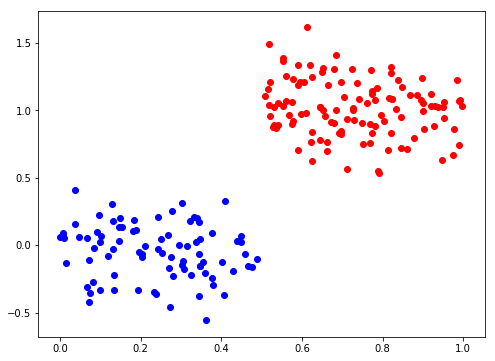

In [51]:
mat0, mat1 = binSplitDataSet(myMat, 0, 0.48813)
mat0 = np.array(mat0)
mat1 = np.array(mat1)
plt.figure(figsize=(8, 6))
plt.scatter(mat0[:, 0], mat0[:, 1], c='r')
plt.scatter(mat1[:, 0], mat1[:, 1], c='b')
plt.show()

In [52]:
myDat1 = loadDataSet('ex0.txt')
myMat1 = np.mat(myDat1)
createTree(myMat1)

{'spInd': 1,
 'spVal': 0.39435,
 'left': {'spInd': 1,
  'spVal': 0.582002,
  'left': {'spInd': 1,
   'spVal': 0.797583,
   'left': 3.9871632,
   'right': 2.9836209534883724},
  'right': 1.980035071428571},
 'right': {'spInd': 1,
  'spVal': 0.197834,
  'left': 1.0289583666666666,
  'right': -0.023838155555555553}}

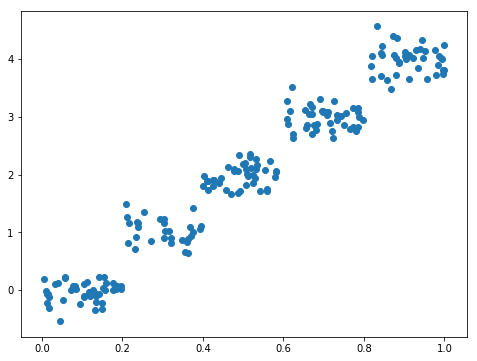

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(np.array(myMat1[:, 1]), np.array(myMat1[:, 2]))
plt.show()

## 2. 树剪枝